In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import kagglehub
import os

In [2]:
path = kagglehub.dataset_download("siarheizavaryn/ab-test-proportions")
df_kaggle = pd.read_csv(path + "\\" + os.listdir(path)[0])
df_kaggle.head()
df = df_kaggle.copy()
df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 79.5k/79.5k [00:00<00:00, 230kB/s]

Extracting files...


,user_id,group,converted
0,198i8h5d184ax7bceafa,A,0
1,198262c2be41x80c4a0d,B,0
2,1989did7d57ex7dc46e72,B,1
3,1986252b0077x7f34ffaa,A,0
4,1985bi134399x599d1286,B,1


In [3]:
def explore_dataset(
    in_df:             pd.DataFrame
    , in_ids:          tuple
    , in_types_dict:   dict
    , out_size_text    = "- dataset size"
    , out_dup_text     = "- number of fully duplicated rows"
    , out_missed_text  = "Columns are expected but not found in the dataset: "
)                      -> pd.DataFrame:
    """
    Quick dataset overview for EDA
    """
    print(f"{in_df.shape[0]} {out_size_text}")
    print(f"{in_df.duplicated().sum()} {out_dup_text}")
    
    for ids in in_ids:
        dup_ids = in_df[ids].duplicated().sum()
        if dup_ids > 0:
            print(f"{dup_ids} - number of duplicated {ids}")
        else:
            print(f"No duplicated {ids}")
    
    out_df = pd.DataFrame(in_df.dtypes, columns=["primary_type"])\
                          .reset_index()\
                          .rename(columns={"index": "column"})
    
    out_df["desired_type"]     = out_df["column"].map(in_types_dict)
    out_df['count']            = in_df.count().values
    out_df['null_values']      = in_df.isnull().sum().values
    out_df['unique_values']    = in_df.nunique().values
    
    missing_columns = [col for col in in_types_dict.keys() if col not in in_df.columns]
    if missing_columns:
        print(f"{out_missed_text} {missing_columns}")
    
    return out_df

In [4]:
explore_dataset(
    in_df            = df
    , in_ids         = ("user_id", )
    , in_types_dict  = {
                        "user_id": str
                        , "group": str
                        , "converted": int
                    }
)

6640 - dataset size
0 - number of fully duplicated rows
No duplicated user_id


,column,primary_type,desired_type,count,null_values,unique_values
0,user_id,object,<class 'str'>,6640,0,6640
1,group,object,<class 'str'>,6640,0,2
2,converted,int64,<class 'int'>,6640,0,2


In [5]:
class StatTestProportionTwoSamples():
    def __init__(
        self
        , data_a
        , data_b
        , tails     = 2
        , alpha     = 0.05
        , name_a    = "Group A"
        , name_b    = "Group B"
    ):
        """
        This class is for unpaired test of two groups with binomial distribution
        """
        try:
            #samples data
            self.array_a, self.array_b = np.array(data_a), np.array(data_b)
            
            if len(self.array_a) == 0 or len(self.array_b) == 0:
                raise ValueError("No data in array")

            #test parameters
            self.tails = tails
            
            if self.tails not in (1, 2):
                raise ValueError("tails must be 1 or 2")

            self.alpha = alpha
            self.z_critical = (norm.ppf(1 - alpha) 
                                if self.tails == 1
                                else norm.ppf(1 - alpha / 2))
            
            self.name_a, self.name_b = name_a, name_b
        except:
            print("Incorrect data format")            
            
    def sample_stats(self):            
        #samples size
        self.size_a, self.size_b            = len(self.array_a), len(self.array_b)
            
        #samples mean
        self.mean_a, self.mean_b            = float(np.mean(self.array_a)), float(np.mean(self.array_b))
        
        #variance
        self.var_a, self.var_b              = (self.mean_a * (1 - self.mean_a)
                                                , self.mean_b * (1 - self.mean_b))
        
        #st dev
        self.std_a, self.std_b              = (float(np.sqrt(self.mean_a * (1 - self.mean_a) / self.size_a))
                                                , float(np.sqrt(self.mean_b * (1 - self.mean_b) / self.size_b)))

        #st errors
        self.st_err_a, self.st_err_b        = (float(np.sqrt(self.mean_a * (1 - self.mean_a) / self.size_a))
                                                , float(np.sqrt(self.mean_b * (1 - self.mean_b) / self.size_b)))

        #common st err 
        self.st_err_pooled                  = float(np.sqrt(self.st_err_a**2 + self.st_err_b**2))
        
        #confidence intervals
        ci_level                            = 0.95
        z_value                             = norm.ppf(1 - (1 - ci_level) / 2)
        self.ci_left_a, self.ci_right_a     = (self.mean_a - z_value * self.st_err_a
                                                , self.mean_a + z_value * self.st_err_a)
        self.ci_left_b, self.ci_right_b     = (self.mean_b - z_value * self.st_err_b
                                                , self.mean_b + z_value * self.st_err_b)
        
        print(f"""
{self.name_a}:
Size: {self.size_a}
Mean: {self.mean_a:.4f}, [{self.ci_left_a:.4f}, {self.ci_right_a:.4f}] CI 95%
Variation: {self.var_a:.6f}
Standard deviation: {self.std_a:.6f}
Standart error: {self.st_err_a:.6f}

{self.name_b}:
Size: {self.size_b}
Mean: {self.mean_b:.4f}, [{self.ci_left_b:.4f}, {self.ci_right_b:.4f}] CI 95%
Variation: {self.var_b:.6f}
Standard deviation: {self.std_b:.6f}
Standart error: {self.st_err_b:.6f}
""")

    def check_variances(self):
        if self.var_a / self.var_b < 2 and self.var_b / self.var_a < 2:
            print(f"""
Variance check: Ok! 
{self.var_a:.4f} and {self.var_b:.4f} are close enough by Rule of Thumb
""")
        else:
            print(f"""
Variance check: Not ok! 
{self.var_a:.4f} and {self.var_b:.4f} are NOT close enough by Rule of Thumb
""")
    
    def check_normality(self):
        n_a = self.size_a
        n_b = self.size_b
        p_a = self.mean_a
        p_b = self.mean_b
        np_nq_values = [
            round(n_a * p_a)
            , round(n_a * (1 - p_a))
            , round(n_b * p_b)
            , round(n_b * (1 - p_b))
        ]
        if any(value < 5 for value in np_nq_values):
            print(f"""
Normality check: Not ok! 
The normal approximation is NOT appliable to the binomial distribution.
Some of np and nq are < 5: {np_nq_values}
We need to have a larger sample or more positive outcomes.\n""")
        else:
            print(f"""
Normality check: Ok! 
The normal approximation is appliable to the binomial distribution.
All np and nq are >= 5: {np_nq_values}\n""")
            
    def test_stats(self):
        """
        Calculating z-statistics and p-value
        """
        self.SE              = float(np.sqrt(
                                self.mean_a * (1 - self.mean_a) / self.size_a 
                                + self.mean_b * (1 - self.mean_b) / self.size_b))
        
        self.z_score         = (self.mean_a - self.mean_b) / self.SE

        self.z_critical      = (self.z_critical
                                if self.z_score >=0
                                else -self.z_critical)

        self.p_value         = (1 - norm.cdf(abs(self.z_score))
                                if self.tails == 1
                                else 2 * (1 - norm.cdf(abs(self.z_score))))
        
        if self.p_value < self.alpha:
            reject = "Reject H0"
        else:
            reject = "Fail to reject H0"
        
        print(f"""
SE: {self.SE:.5f}
z_score: {self.z_score:.5f}
z_critical: {self.z_critical:.5f}
p_value: {self.p_value:.10f}

Conclusion: {reject}
""")
        
    def samples_plot(
        self
        , color_a = "blue"
        , color_b = "orange"
    ):
        """
        Density functions for normal distributions for samples data with mean and ci markers 
        """
        
        #x range for linspace
        threshold_a_upper     = self.mean_a + self.z_critical * self.st_err_a
        threshold_a_lower     = (self.mean_a - self.z_critical * self.st_err_a 
                                    if self.tails == 2
                                    else self.mean_a)

        threshold_b_upper     = self.mean_b + self.z_critical * self.st_err_b
        threshold_b_lower     = (self.mean_b - self.z_critical * self.st_err_b 
                                    if self.tails == 2\
                                    else self.mean_b)

        lin_start             = min(self.ci_left_a, self.ci_left_b
                                , threshold_a_lower, threshold_b_lower) - 0.001
        lin_end               = max(self.ci_right_a, self.ci_right_b
                              , threshold_a_upper, threshold_b_upper) + 0.001
        x                     = np.linspace(lin_start, lin_end, 1000)

        #normal distribution
        pdf_a                 = norm.pdf(x, self.mean_a, self.st_err_a)
        pdf_b                 = norm.pdf(x, self.mean_b, self.st_err_b)

        fig, ax               = plt.subplots(figsize = (10, 6))

        ax.plot(x, pdf_a, label = f"{self.name_a}", color = color_a, linewidth = 2)
        ax.plot(x, pdf_b, label = f"{self.name_b}", color = color_b, linewidth = 2)

        #means
        ax.axvline(self.mean_a, color = color_a, linestyle= "--", linewidth = 2
                   , label=f"Mean {self.name_a}: {self.mean_a:.4f}")
        ax.axvline(self.mean_b, color = color_b, linestyle= "--", linewidth = 2
                   , label=f"Mean {self.name_b}: {self.mean_b:.4f}")

        #ci
        ax.axvline(self.ci_left_a, color = color_a, linestyle= ":", linewidth = 1)
        ax.axvline(self.ci_right_a, color = color_a, linestyle= ":", linewidth = 1
                   , label = f"CI A [{self.ci_left_a:.4f}, {self.ci_right_a:.4f}]")
        
        ax.axvline(self.ci_left_b, color = color_b, linestyle= ":", linewidth = 1)
        ax.axvline(self.ci_right_b, color = color_b, linestyle= ":", linewidth = 1
                   , label = f"CI B [{self.ci_left_b:.4f}, {self.ci_right_b:.4f}]")        
        
        ax.set_xlabel("Proportion")
        ax.set_ylabel("Density")
        ax.set_title(f"Normal Distributions of Proportions for {self.name_a} and {self.name_b}")
        ax.legend()

        plt.show()                

    
    def z_stat_plot(self):
        """
        Density function for normal distributions for z-statistics with critical levels 
        """
        x_z             = np.linspace(-4, 4, 1000)
        pdf_z           = norm.pdf(x_z, 0, 1)

        fig, ax         = plt.subplots(figsize = (10, 6))

        ax.plot(x_z, pdf_z, label = "Standard Normal Distribution", color = "black")

        #alpha region for significance
        if self.tails == 1:
            ax.fill_between(x_z, 0, pdf_z, where = (x_z >= self.z_critical if self.z_critical > 0 else x_z <= self.z_critical)
                            , color = "red", alpha = 0.2
                            , label = "Alpha Region (Significance Level)")
        else:
            ax.fill_between(x_z, 0, pdf_z, where = (x_z >= abs(self.z_critical)) | (x_z <= -abs(self.z_critical))
                            , color = "red", alpha = 0.2
                            , label = "Alpha Region (Significance Level)")

        #calculated z-score
        ax.axvline(self.z_score, color = "purple", linestyle = "-", linewidth = 2
                   , label = f"Calculated Z-Score = {self.z_score:.2f}")

        #critical z-score
        ax.axvline(self.z_critical, color = "blue", linestyle = "--", linewidth = 1.5
                   , label = f"Critical Z-Score = {self.z_critical:.2f}")
        if self.tails == 2:
            ax.axvline(-self.z_critical, color = "blue", linestyle = "--", linewidth = 1.5)

        ax.set_xlabel("Z-Score")
        ax.set_ylabel("Density")
        ax.set_title("Z-Statistic Distribution for Two Proportions Comparison")
        ax.legend()

        plt.show()

    def output_data(self):
        """
        All related data as a dict
        """
        out = {
            "size_a":         self.size_a
            , "mean_a":       self.mean_a
            , "var_a":        self.var_a
            , "std_a":        self.std_a
            , "st_err_a":     self.st_err_a
            , "ci_a":         [self.ci_left_a, self.ci_right_a]
            , "size_b":       self.size_b
            , "mean_b":       self.mean_b
            , "var_b":        self.var_b
            , "std_b":        self.std_b
            , "st_err_b":     self.st_err_b
            , "ci_b":         [self.ci_left_b, self.ci_right_b]
            , "se":           self.SE
            , "z_score":      self.z_score
            , "z_critical":   self.z_critical
            , "p_value":      self.p_value
        }
        return out


Group A:
Size: 3338
Mean: 0.2262, [0.2120, 0.2404] CI 95%
Variation: 0.175024
Standard deviation: 0.007241
Standart error: 0.007241

Group B:
Size: 3302
Mean: 0.2435, [0.2288, 0.2581] CI 95%
Variation: 0.184202
Standard deviation: 0.007469
Standart error: 0.007469


Normality check: Ok! 
The normal approximation is appliable to the binomial distribution.
All np and nq are >= 5: [755, 2583, 804, 2498]


Variance check: Ok! 
0.1750 and 0.1842 are close enough by Rule of Thumb


SE: 0.01040
z_score: -1.66353
z_critical: -1.95996
p_value: 0.0962058322

Conclusion: Fail to reject H0



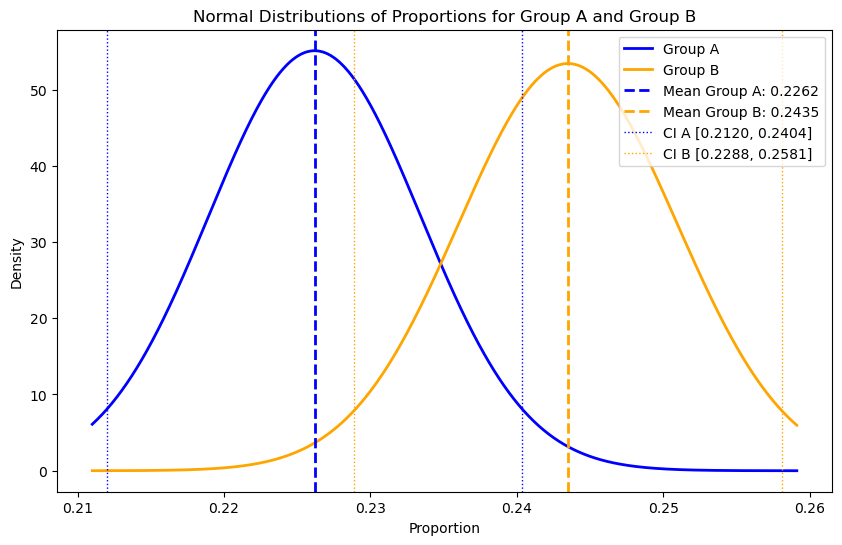

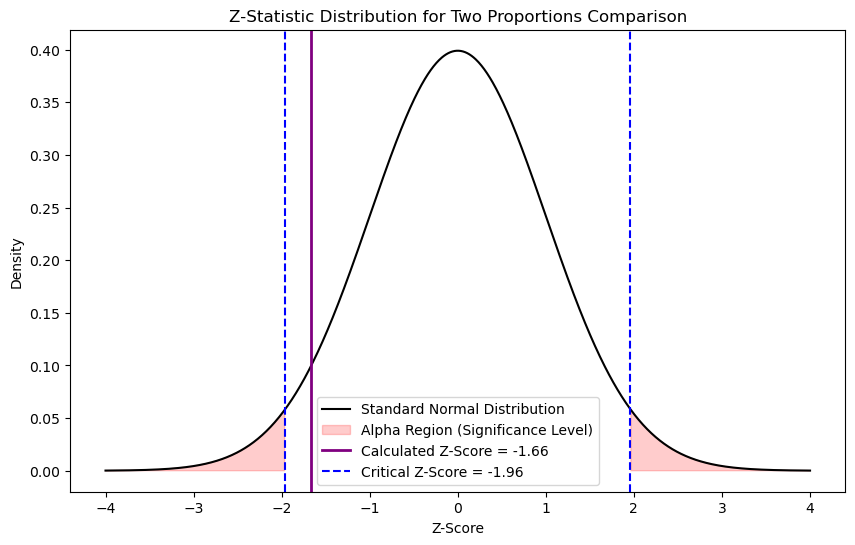

In [6]:
group_a = df[df["group"] == "A"]["converted"]
group_b = df[df["group"] == "B"]["converted"]

f = StatTestProportionTwoSamples(group_a, group_b, tails = 2)
f.sample_stats()
f.check_normality()
f.check_variances()
f.test_stats()
f.samples_plot()
f.z_stat_plot()